In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import math
import time
import os
import random

import sys
sys.path.insert(0,'..')

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:7


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 23

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (3, 2, 2081)
GT S-parameters shape:  (3, 2, 2081)
Y S-parameters shape:  (3, 2, 155)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (2081,)
Y frequencies shape:  (155,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  40000000.0
Mean frequency spacing:  19211538.46153846
STD frequency spacing:  6057692.307692306
Mode frequency spacing:  18000000.0
Number of samples with non-equal spacing:  81


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  2081
N_SPARAMS:  3


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 6, 2081])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 3, 2081])


## Plot some stuff

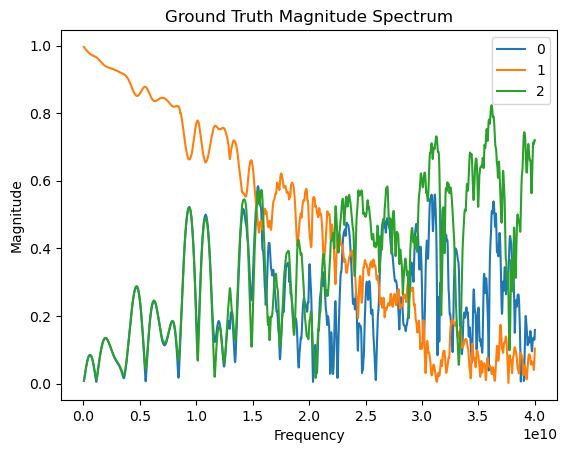

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

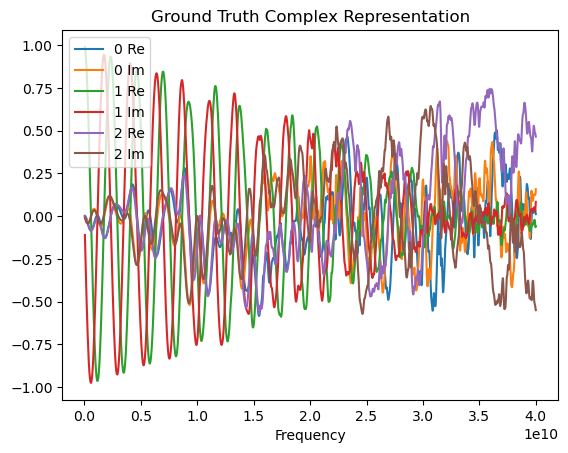

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "equal" #[random, equal, forecast, full, log, sqrt]
# M = int(0.10 * N_FREQS)
M = 2

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)
print(kept_inds)

Number of Ground Truth Frequency Points:  2081
Number of Measurements:  2
Undersampling Ratio:  0.0009610764055742432
[   0 2080]


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 6, 2])
y_freqs shape:  (2,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ

NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False
USE_SGLD = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  6
NUM_LAYERS:  8
BASE NGF:  16
NGF:  [16, 16, 16, 16, 16, 16, 16, 16]
BS:  1
NC:  6
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE,
               p_dropout=0.0
               )
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 6, 2081])


/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/torch/nn/functional.py:1338: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn("dropout2d: Received a 3D input to dropout2d and assuming that channel-wise "


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  30098


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
#grab the correct file we want for VF
NUM_ACTIVE = 153

LR = 2e-4
NUM_ITER = 2000
TOTAL_ITERS = NUM_ITER * (NUM_ACTIVE + 1)
NUM_BURN_ITER = NUM_ITER * 0 # 0.2
SAMPLE_EVERY = 40

ACTIVE_ITER_RATIO = 0.1
SAMPLE_LAST_N = NUM_ITER * ACTIVE_ITER_RATIO

# TODO: maybe come back to this?
# TOTAL_ITER = NUM_ITER + 0.1 * NUM_ACTIVE * NUM_ITER

REG_HYPERPARAM = 1.0
NOISY_INPUT = True
USE_SGLD = False

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

optim = torch.optim.Adam(net.parameters(), lr=LR)

def get_lr(optim):
    for g in optim.param_groups:
        return g['lr']
    
def set_lr(optim, lr):
    for g in optim.param_groups:
        g['lr'] = lr
        
START_NOISE_LEVEL = CUR_NOISE_LEVEL = 1.0
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / TOTAL_ITERS) 

START_LR = LR
END_LR = 1e-5
LR_DECAY_FACTOR = 1 # (END_LR / START_LR)**(1 / NUM_ITER)


train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

is_initial_fit = True
tic = time.time()
net.train()

# (NUM_ACTIVE + 1) * NUM_OUTPUTS * S_PARAMS * FREQS
sgld_outputs_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_means_by_sample = []
# (NUM_ACTIVE + 1) * S_PARAMS * FREQS
sgld_stds_by_sample = []

for num_actively_sampled in range(NUM_ACTIVE + 1):

    cur_sgld_outputs = torch.Tensor().to(device)   

    if not is_initial_fit:

        # Find the maximum standard deviation point, and use it to update kept_inds
        max_disagree_idx = find_max_variance(sgld_outputs_by_sample[-1], pickRandom=True)
        kept_inds = np.sort(np.append(kept_inds, max_disagree_idx))
        print(kept_inds)

        # Recreate the y data with the new kept_inds
        y = torch.clone(x)[:, :, kept_inds]
        y_freqs = gt_freqs[kept_inds]

        # Update the LR and noise level based on our decay rates
        set_lr(optim, START_LR * LR_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) * NUM_ITER / ACTIVE_ITER_RATIO))
        # CUR_NOISE_LEVEL = START_NOISE_LEVEL * NOISE_DECAY_FACTOR**((1 - ACTIVE_ITER_RATIO) *  NUM_ITER / ACTIVE_ITER_RATIO)

    # Update the criterion to reflect the new point we have sampled
    criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
    criterion = criterion.to(device)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=LR_DECAY_FACTOR)


    for i in range(int(NUM_ITER)):
        optim.zero_grad()
        
        if NOISY_INPUT:
            out = net.forward_with_z(CUR_NOISE_LEVEL)
            CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
        else:
            out = net.forward_with_z()
        
        train_error = criterion(out, y) 
        if REG_HYPERPARAM > 0:
            train_reg = REG_HYPERPARAM * regularizer(out)
            train_loss = train_error + train_reg
        else:
            train_loss = train_error
        
        train_loss.backward()
        optim.step()
        scheduler.step()

        with torch.no_grad():
            # First 20% of training will be burn-in iterations
            if (not is_initial_fit or i > NUM_BURN_ITER) and USE_SGLD:
                # Perform SGLD by adding Gaussian noise to parameters after gradient descent
                for param in net.parameters():
                    # param.add_(torch.normal(0, get_lr(optim), size=param.size()).to(device))
                    param.add_(torch.randn_like(param) * get_lr(optim) * 2)
            
            # Log the standard metrics across different numbers of samples given
            train_losses.append(train_loss.item())
            train_errors.append(train_error.item())
            if REG_HYPERPARAM > 0:
                train_regs.append(train_reg.item())
            
            test_mse = nn.MSELoss()(out, x)
            test_mses.append(test_mse.item())
            
            test_mae = nn.L1Loss()(out, x)
            test_maes.append(test_mae.item())

            if (i+1)%1000 == 0 or i == 0:
                toc = time.time()
                print("ITER ", str(i))
                print("TIME: ", str(toc - tic))
                if NOISY_INPUT:
                    print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
                print()

            # Get SGLD outputs for finding mean/std
            if (NUM_ITER - i <= SAMPLE_LAST_N) and i % SAMPLE_EVERY == 0:
                cur_sgld_outputs = torch.cat([cur_sgld_outputs, out])

    sgld_outputs_by_sample.append(cur_sgld_outputs)
    sgld_means_by_sample.append(torch.mean(cur_sgld_outputs, dim=0))
    sgld_stds_by_sample.append(torch.std(cur_sgld_outputs, dim=0))

    if is_initial_fit :
    #     NUM_ITER *= ACTIVE_ITER_RATIO
        is_initial_fit = False


    def find_max_variance(outputs, pickRandom=False):
        # Outputs of shape [NUM_OUTPUTS, 20, 1000]

        # Call np.var with dim = 0 to get shape [20, 1000]
        var_output = torch.var(outputs, dim=0)

        # Sum to go to [1000]
        var_output = torch.sum(var_output, dim=0)

        if pickRandom:
            while True:
                rand_idx = random.randint(0, len(var_output) - 1)
                if rand_idx not in kept_inds:
                    print("picked: ", rand_idx)
                    return rand_idx

        _, idxs = torch.topk(var_output, len(var_output))

        for idx in idxs:
            if idx.item() not in kept_inds:
                return idx.item()
        return -1
    
    print("NUM_SAMPLES ", str(num_actively_sampled))
    print("TIME: ", str(toc - tic))


ITER  0
TIME:  0.254763126373291
NOISE LEVEL:  0.9999775724746209

ITER  999
TIME:  28.306437253952026
NOISE LEVEL:  0.9778218559886167

ITER  1999
TIME:  56.23912978172302
NOISE LEVEL:  0.9561355820490228

NUM_SAMPLES  0
TIME:  56.23912978172302
picked:  1777
[   0 1777 2080]
ITER  0
TIME:  56.2702956199646
NOISE LEVEL:  0.9561141382939906

ITER  999
TIME:  84.45858097076416
NOISE LEVEL:  0.9349302694159288

ITER  1999
TIME:  112.41386437416077
NOISE LEVEL:  0.9141952512602215

NUM_SAMPLES  1
TIME:  112.41386437416077
picked:  1623
[   0 1623 1777 2080]
ITER  0
TIME:  112.44140863418579
NOISE LEVEL:  0.9141747481230225

ITER  999
TIME:  139.5622386932373
NOISE LEVEL:  0.8939200973232492

ITER  1999
TIME:  166.66542387008667
NOISE LEVEL:  0.8740946086701443

NUM_SAMPLES  2
TIME:  166.66542387008667
picked:  1483
[   0 1483 1623 1777 2080]
ITER  0
TIME:  166.6968183517456
NOISE LEVEL:  0.8740750048911247

ITER  999
TIME:  194.06507325172424
NOISE LEVEL:  0.8547088125594833

ITER  1999
T

In [23]:
# NUM_FORWARD_PASSES = 100
# sums_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# sums_squared_forward_pass_outputs = torch.Tensor(np.zeros(shape=test_out.shape, dtype=np.float32))
# for i in range(NUM_FORWARD_PASSES):
#     sums_forward_pass_outputs += net.forward_with_z().cpu()
#     sums_squared_forward_pass_outputs += torch.square(net.forward_with_z()).cpu()

# mean_forward_pass_outputs = sums_forward_pass_outputs / NUM_FORWARD_PASSES
# std_forward_pass_outputs = torch.sqrt(((NUM_FORWARD_PASSES * sums_squared_forward_pass_outputs) - (sums_forward_pass_outputs * sums_forward_pass_outputs)) / (NUM_FORWARD_PASSES * (NUM_FORWARD_PASSES - 1)))

print(sgld_outputs_by_sample[0].shape)
print(sgld_means_by_sample[0].shape)
print(sgld_stds_by_sample[0].shape)

torch.Size([5, 6, 2081])
torch.Size([6, 2081])
torch.Size([6, 2081])


## Plot metrics and outputs

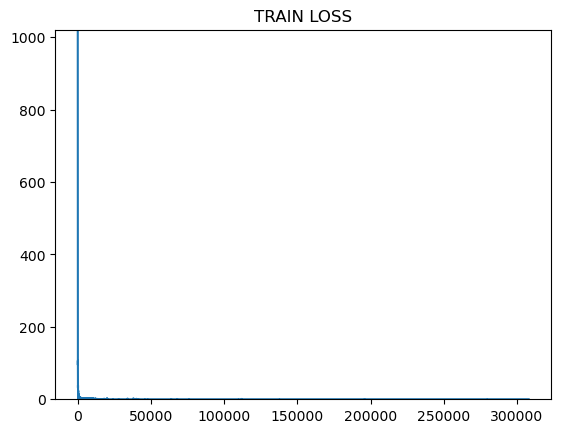

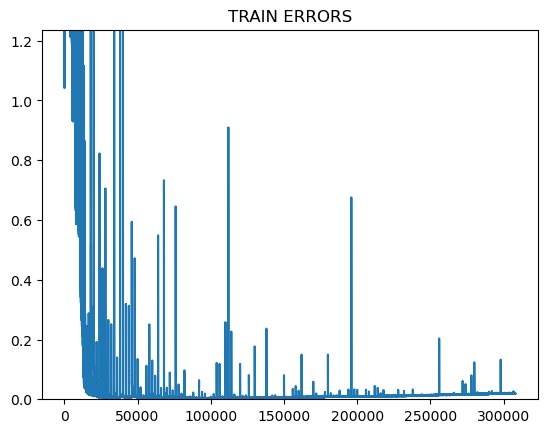

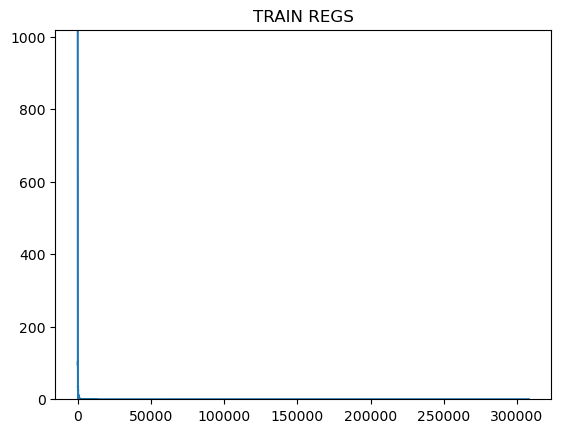

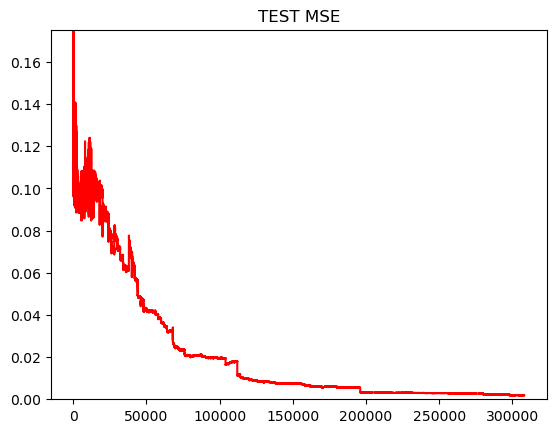

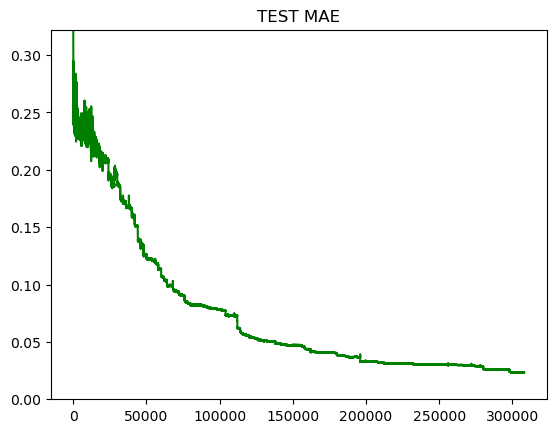

In [24]:
max_idx = 0

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [25]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.0019193864427506924
Best Test MSE:  0.0018994370475411415
Best Test MSE Iteration:  298011


In [26]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
print(y_freqs)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)
print(vf_data.shape)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case23/case23.s2p
[4.0000e+07 5.3500e+08 1.4755e+09 2.0695e+09 2.5645e+09 3.8515e+09
 4.2340e+09 5.1880e+09 5.3860e+09 5.6740e+09 6.3400e+09 6.3760e+09
 6.5560e+09 6.6820e+09 6.9520e+09 7.0060e+09 7.6540e+09 7.7620e+09
 7.7800e+09 7.9780e+09 8.4820e+09 8.5360e+09 8.7520e+09 9.2380e+09
 9.5440e+09 9.6340e+09 9.9220e+09 9.9400e+09 1.0138e+10 1.0588e+10
 1.0660e+10 1.0768e+10 1.0858e+10 1.0930e+10 1.0984e+10 1.1290e+10
 1.1344e+10 1.1416e+10 1.1470e+10 1.1560e+10 1.1758e+10 1.1920e+10
 1.1956e+10 1.2136e+10 1.2262e+10 1.2352e+10 1.2496e+10 1.2586e+10
 1.2694e+10 1.3054e+10 1.3720e+10 1.4620e+10 1.5286e+10 1.5898e+10
 1.5916e+10 1.6276e+10 1.6384e+10 1.6924e+10 1.7068e+10 1.7338e+10
 1.8004e+10 1.8022e+10 1.8220e+10 1.8310e+10 1.8364e+10 1.8472e+10
 1.8652e+10 1.8868e+10 1.9282e+10 1.9714e+10 2.0920e+10 2.1118e+10
 2.1136e+10 2.1478e+10 2.1838e+10 2.2072e+10 2.2252e+10 2.2396e+10
 2.2648e+10 2.2810e+10 2.2900e+10 2.3062e+10 2.3134e+10 2.3188e+1

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/skrf/vectorFitting.py:869: RuntimeWarning: invalid value encountered in sqrt
  for sqrt_eigenval in np.sqrt(P_eigs):


  Fitting took 0.18737483397126198 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.


/u/bodeng/CurveFitting-DIP/random_sampling/../VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. Hint: the linear system was ill-conditioned (max. condition number = 529020104226.55975). This often means that more poles are required.
  vf.vector_fit(n_poles_cmplx=n_poles)
/u/bodeng/CurveFitting-DIP/random_sampling/../VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.15688325464725494 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 3 was not subtantially better than 2 (err 1.5385707931477528 vs 1.3484597373263405)
Performing fit with 3 poles.
  Fitting took 0.15882335789501667 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 was not subtantially better than 2 (err 1.9021283028210887 vs 1.3484597373263405)
Performing fit with 4 poles.
  Fitting took 0.08868616446852684 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 was not subtantially better than 2 (err 1.8987546628727883 vs 1.3484597373263405)
Fit completed in 0.7664563655853271, using 4, resulting in a fit with 2 and error=1.3484597373263405 vs samples and error=1.596071567304909 vs ground truth.
(2081, 2, 2)
complex128
torch.Size([1, 6, 2081])


In [27]:
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_data_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_data_mat.shape)
print(dip_data.dtype)
print(vf_data_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_data_mat)
print("DIP PSNR:      ", psnr_ours)
print("VF PSNR:       ", psnr_vf)

print("Final DIP MSE: ", test_mses[-1])
print("VF MSE:        ", nn.MSELoss()(vf_data, x).item())
print("Mean DIP MSE: ", nn.MSELoss()(sgld_means_by_sample[-1][np.newaxis], x).item())

torch.Size([2081, 2, 2, 2])
torch.Size([2081, 2, 2, 2])
torch.Size([155, 2, 2, 2])
(2081, 2, 2, 2)
(2081, 2, 2, 2)
(3, 2, 2081)
(3, 2, 2081)
float32
float32
DIP PSNR:       33.18897571432218
VF PSNR:        16.65195561176036
Final DIP MSE:  0.0019193864427506924
VF MSE:         0.08646979928016663
Mean DIP MSE:  0.0019150156294927


(2081,)
torch.Size([6, 2081])
torch.Size([1, 6, 2081])
torch.Size([1, 6, 155])
torch.Size([1, 6, 2081])
torch.Size([1, 6, 2081])


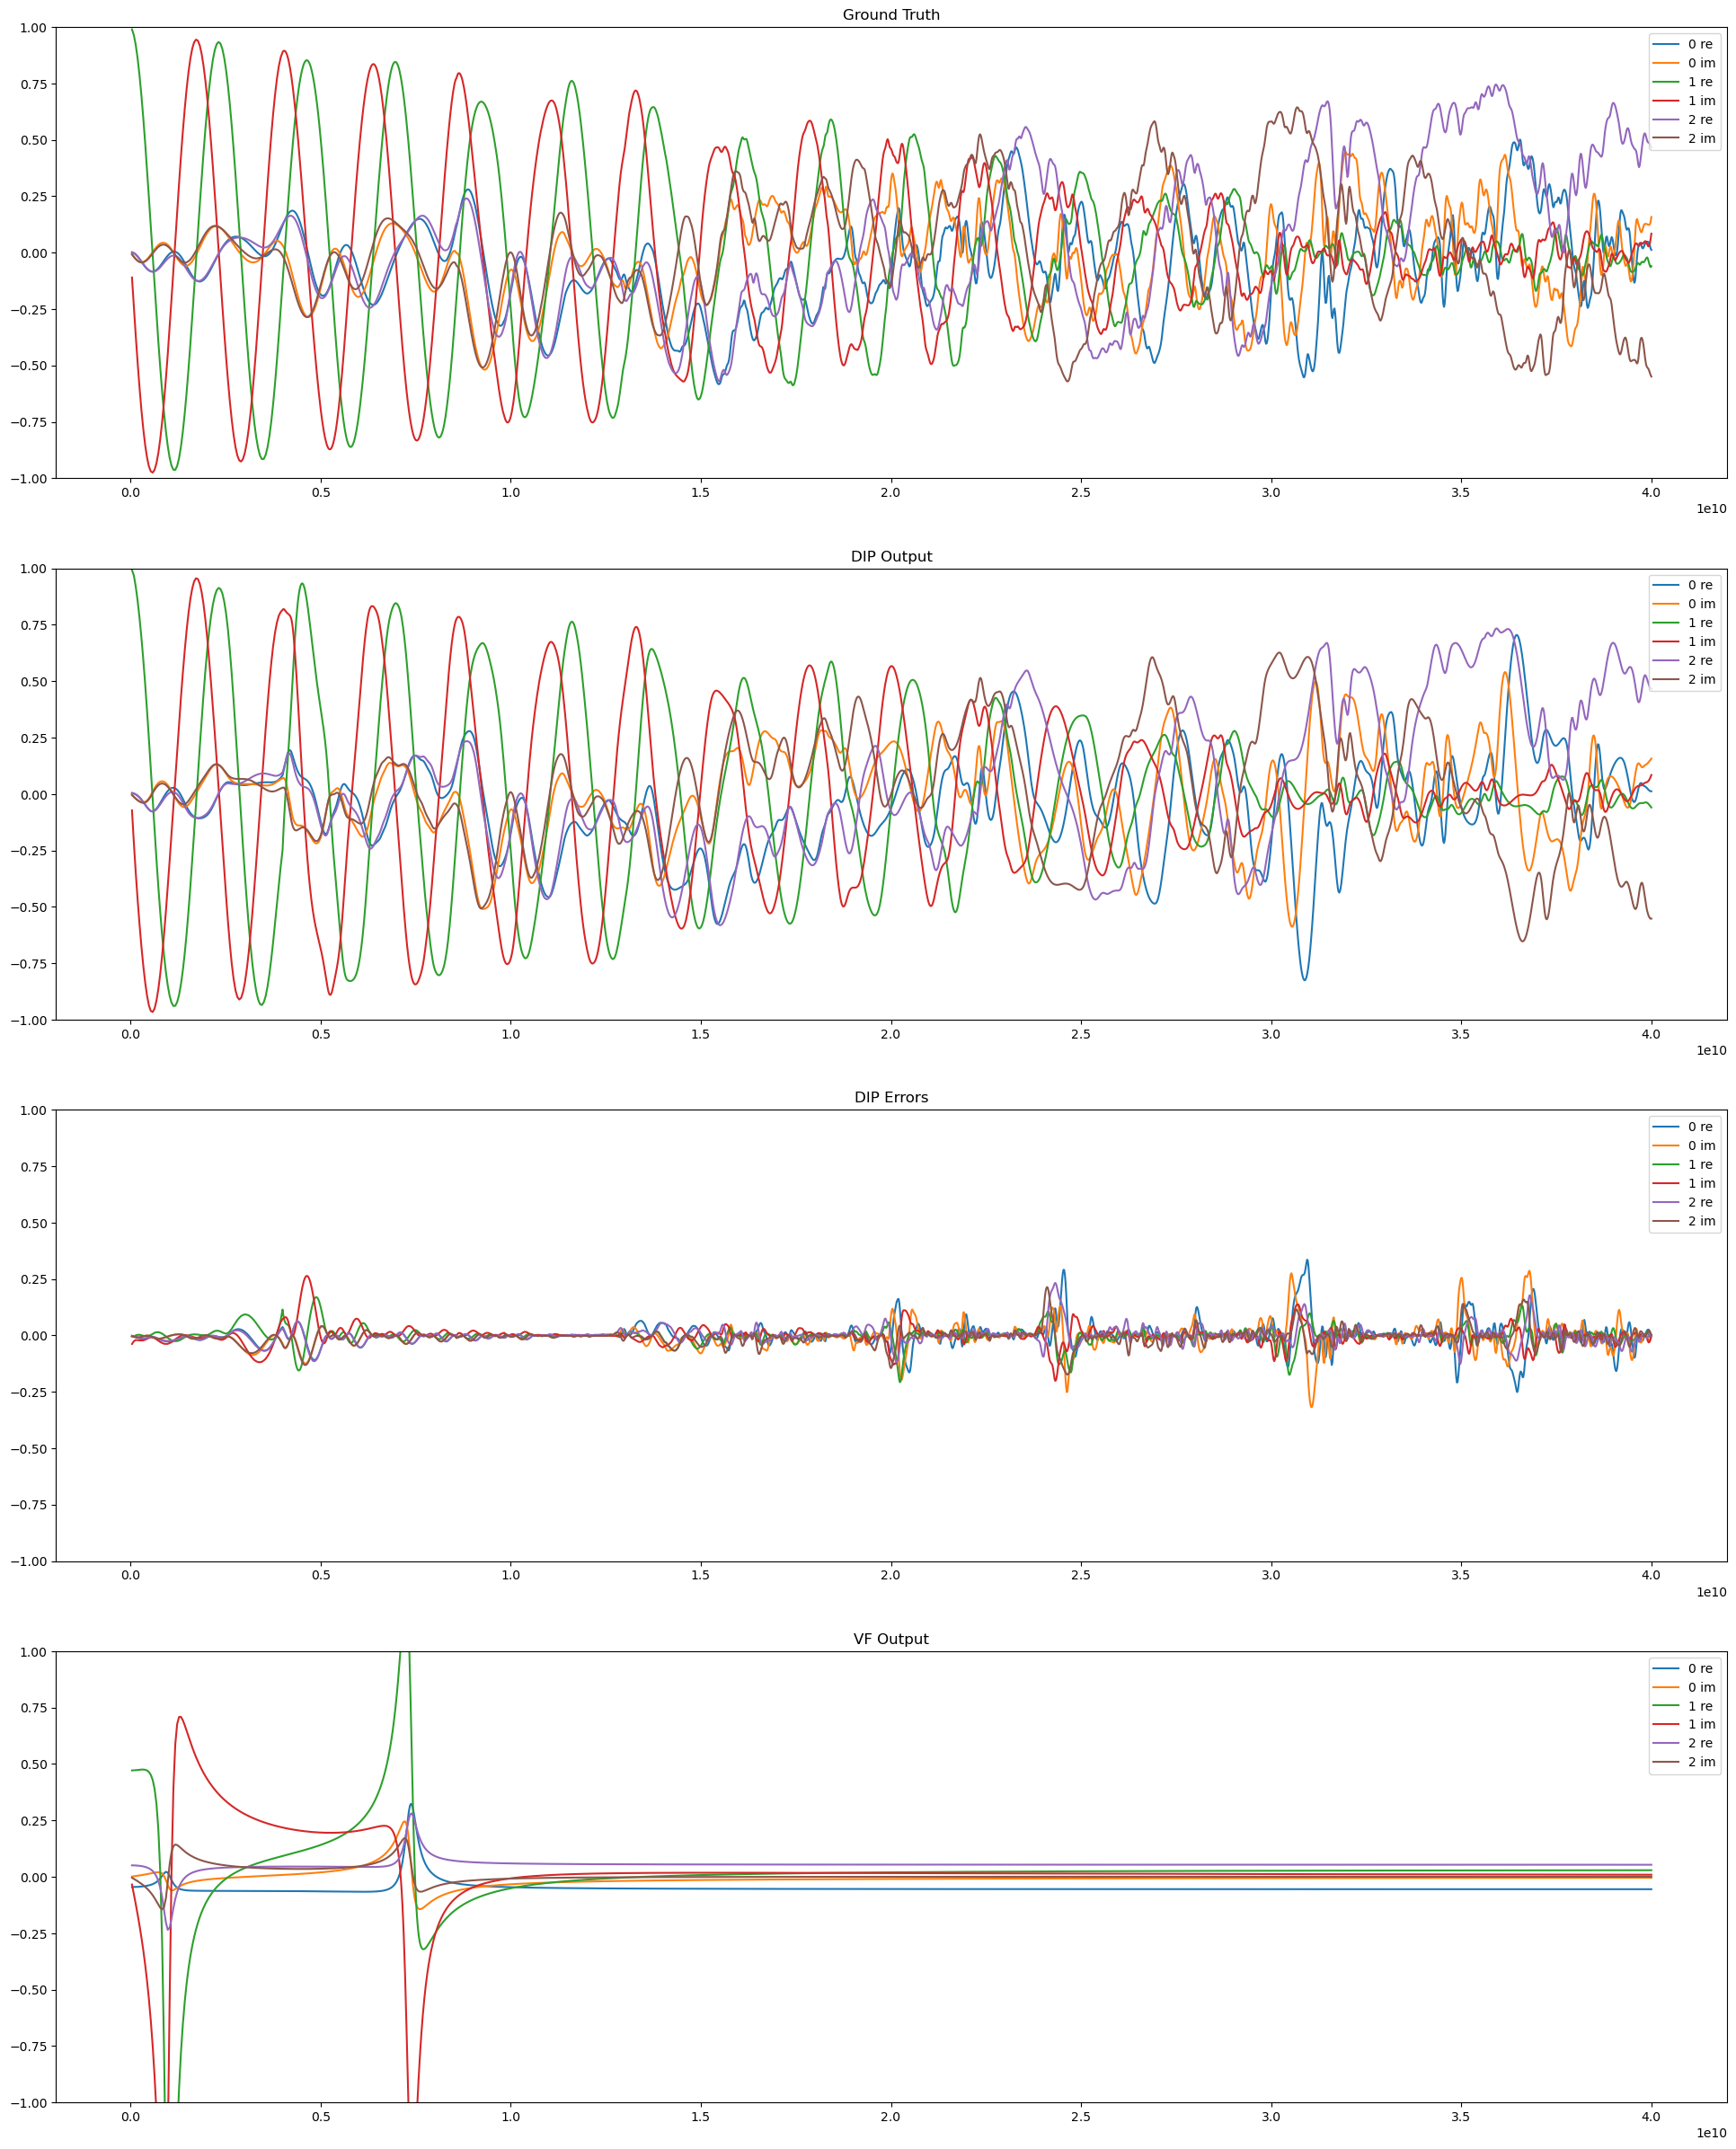

In [28]:
dip_errors = x.detach().cpu() - sgld_means_by_sample[-1].detach().cpu()
print(gt_freqs.shape)
print(sgld_means_by_sample[-1].shape)
print(dip_errors.shape)
print(y.shape)

print(out.shape)
print(vf_data.shape)

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

# SHOW WITH MEAN AND STD DEVS
# for i in range(N_SPARAMS):

#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu(), label=str(i)+" re")
#     axes[1].plot(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu(), label=str(i)+" im")
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i].detach().cpu(), sgld_means_by_sample[-1][2*i].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i].detach().cpu())
#     axes[1].fill_between(gt_freqs, sgld_means_by_sample[-1][2*i+1].detach().cpu() - 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu(), sgld_means_by_sample[-1][2*i+1].detach().cpu() + 2 * sgld_stds_by_sample[-1][2*i+1].detach().cpu())

#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i].cpu(), color='black')
#     # axes[1].scatter(gt_freqs[kept_inds], y[0,2*i+1].cpu(), color='black')


# axes[1].set_title("DIP Output")
# axes[1].set_ylim(-1,1)
# if N_SPARAMS <= 10:
#     axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')

In [29]:
torch.set_printoptions(threshold=100000)
print(sgld_stds_by_sample[-1])

tensor([[9.8912e-04, 1.0088e-03, 1.0478e-03, 1.0401e-03, 9.8710e-04, 9.5811e-04,
         9.5313e-04, 9.5105e-04, 9.5216e-04, 9.3350e-04, 8.9523e-04, 8.3930e-04,
         7.6601e-04, 7.3567e-04, 7.4764e-04, 7.4675e-04, 7.3274e-04, 7.3605e-04,
         7.5720e-04, 7.8040e-04, 8.0534e-04, 8.0628e-04, 7.8272e-04, 7.7273e-04,
         7.7612e-04, 7.6635e-04, 7.4464e-04, 7.2940e-04, 7.1966e-04, 7.0374e-04,
         6.8134e-04, 6.6409e-04, 6.5184e-04, 6.6193e-04, 6.9679e-04, 7.4738e-04,
         8.1015e-04, 8.6158e-04, 9.0072e-04, 9.3159e-04, 9.5533e-04, 9.5176e-04,
         9.2188e-04, 9.0471e-04, 8.9940e-04, 9.1135e-04, 9.4010e-04, 9.4144e-04,
         9.1465e-04, 8.8630e-04, 8.5551e-04, 8.4568e-04, 8.5796e-04, 8.8101e-04,
         9.1383e-04, 9.2509e-04, 9.1537e-04, 9.0421e-04, 8.9159e-04, 8.8098e-04,
         8.7288e-04, 8.4715e-04, 8.0555e-04, 7.8857e-04, 7.9497e-04, 8.1291e-04,
         8.4206e-04, 8.4978e-04, 8.3507e-04, 8.1580e-04, 7.9231e-04, 7.7001e-04,
         7.5066e-04, 7.2751e

In [30]:
print(dip_errors[-1])

tensor([[-2.0897e-03, -3.4564e-03, -5.9768e-03, -9.1613e-03, -1.2255e-02,
         -1.4664e-02, -1.5503e-02, -1.5045e-02, -1.2495e-02, -9.9141e-03,
         -6.8041e-03, -6.3501e-03, -8.4756e-03, -1.1425e-02, -1.5559e-02,
         -1.8968e-02, -2.2354e-02, -2.4419e-02, -2.6030e-02, -2.6291e-02,
         -2.5999e-02, -2.4753e-02, -2.3065e-02, -2.0805e-02, -1.8059e-02,
         -1.5135e-02, -1.1673e-02, -8.6019e-03, -5.2215e-03, -3.9136e-03,
         -3.8254e-03, -5.9680e-03, -9.5468e-03, -1.3485e-02, -1.7220e-02,
         -1.9639e-02, -2.0510e-02, -1.9496e-02, -1.6711e-02, -1.2762e-02,
         -8.0437e-03, -4.2665e-03, -1.9917e-03, -1.2517e-03, -2.6405e-03,
         -4.2698e-03, -6.6487e-03, -7.9025e-03, -8.3791e-03, -6.8427e-03,
         -3.4635e-03,  1.9571e-03,  9.3962e-03,  1.5947e-02,  2.1675e-02,
          2.5536e-02,  2.7627e-02,  2.7602e-02,  2.5561e-02,  2.1543e-02,
          1.5663e-02,  8.2019e-03, -6.7121e-04, -1.0487e-02, -2.0974e-02,
         -3.1599e-02, -4.1964e-02, -5.

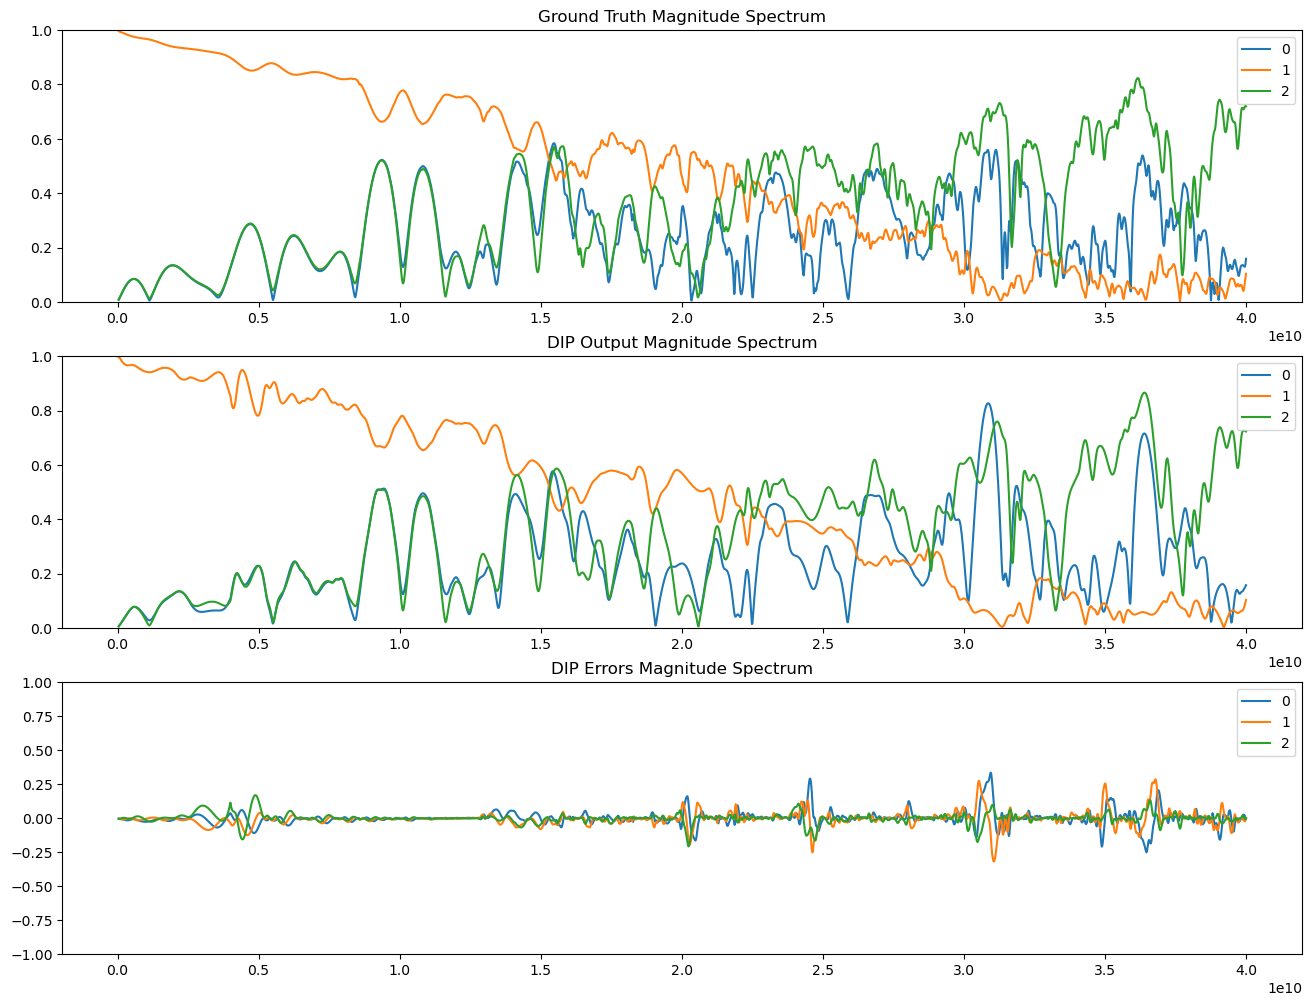

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
print(kept_inds)

[   0   10   29   41   51   77   93  146  157  173  210  212  222  229
  244  247  283  289  290  301  329  332  344  371  388  393  409  410
  421  446  450  456  461  465  468  485  488  492  495  500  511  520
  522  532  539  544  552  557  563  583  620  670  707  741  742  762
  768  798  806  821  858  859  870  875  878  884  894  906  929  953
 1020 1031 1032 1051 1071 1084 1094 1102 1116 1125 1130 1139 1143 1146
 1168 1176 1178 1251 1273 1283 1306 1321 1325 1333 1355 1370 1381 1382
 1385 1403 1432 1445 1449 1457 1461 1472 1483 1500 1502 1516 1539 1597
 1598 1607 1623 1635 1636 1641 1661 1677 1680 1682 1688 1693 1702 1712
 1722 1727 1750 1753 1761 1777 1781 1790 1829 1835 1838 1848 1857 1919
 1924 1935 1958 1959 1966 1975 1987 2004 2012 2043 2044 2060 2069 2071
 2080]
